Libraries

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset analysis

1. Use RIDAGEYR columns to make another group to the age_group. 
Make a function that changes peoples group from "Adult" to "Young" if they are from age 12 to 25.
2. After that, remove RIDAGEYR. 
3. Rename columns to be more comprehensive.


       SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0   73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1   73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2   73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3   73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4   73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   
5   73581.0     Adult      50.0       1.0     2.0    23.6   110.0     2.0   
6   73587.0     Adult      14.0       1.0     2.0    38.7    94.0     2.0   
7   73596.0     Adult      57.0       2.0     2.0    38.3   107.0     2.0   
8   73607.0    Senior      75.0       1.0     2.0    38.9    89.0     2.0   
9   73610.0     Adult      43.0       1.0     1.0    28.9    90.0     2.0   
10  73618.0     Adult      54.0       2.0     2.0    32.7    98.0     2.0   
11  73619.0     Adult      36.0       2.0     1.0    27.3    85.0     2.0   

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


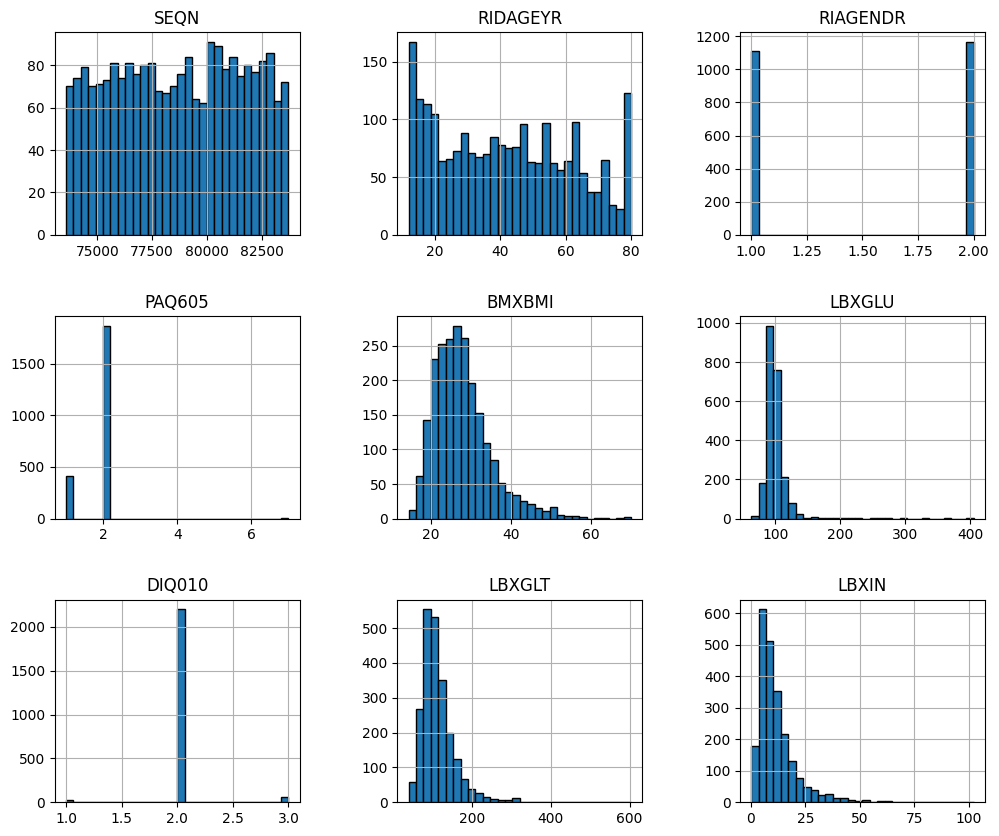

In [362]:
df = pd.read_csv("NHANES_age_prediction.csv")
print(df.head(20))

df.hist(figsize=(12,10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.4, wspace=0.4)
df.describe()

In [363]:
categories_order = [['Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])

X = df.drop(columns = 'age_group')
y = df['age_group']


<Axes: >

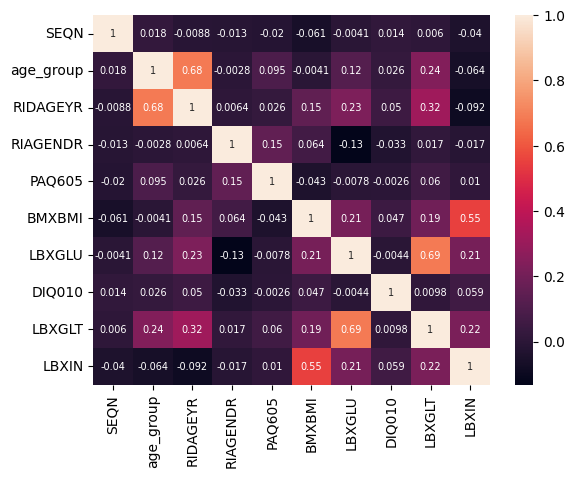

In [364]:
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 7})

1. Take models and train on X_train, y_train
2. Predict age_group
3. Plot metrics like accuracy_score, confussion_matrix, etc.
4. Tune hyperparameters of the models using tune_parameters.

# Model training and evaluation

In [365]:
def checkForOutliers(df):
    fig, axs = plt.subplots(len(df.columns),1,dpi=95, figsize=(7,30))
    axs = np.atleast_1d(axs) 
    for i, col in enumerate(df.columns):
        axs[i].boxplot(df[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()

def dropOutliers(df, drop_list):
    for col in drop_list:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        clean_data = df[(df[col] > lower_bound) 
                        & (df[col] < upper_bound)]
        df = clean_data
    return df

# function to tune hyperparameters of a selected model
# how to write param_grid
param_grid = {
    'classification__penalty': ['l1', 'l2', 'elasticnet', None],
    'classification__max_iter': [100, 200, 500],
    'classification__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'classification__multi_class': ['auto', 'ovr', 'multinomial']
}

def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

def train_predict_evaluate(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=np.nan)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("\nModel:", str(model))
    print("| Accuracy score:", accuracy)
    print("| Precision score:", precision)
    print("| Recall score:", recall)
    print("| F1 score:", f1)
    print("| Confussion matrix:\n", cm)
    

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression(solver='liblinear')
train_predict_evaluate(model, X, y)


model = LogisticRegression(max_iter=200, solver='newton-cg')
train_predict_evaluate(model, X, y)

model = KNeighborsClassifier()
train_predict_evaluate(model, X, y) # cannot tune params


model = DecisionTreeClassifier(random_state=0)
train_predict_evaluate(model, X, y)

model = RandomForestClassifier(max_depth= 2, min_samples_split= 2, n_estimators= 100) # good enough
train_predict_evaluate(model, X, y)

model = SVC()
train_predict_evaluate(model, X, y) # cannot tune params

model = GaussianNB()
train_predict_evaluate(model, X, y) # cannot tune params

model = GradientBoostingClassifier(ccp_alpha= 0.01, loss= 'log_loss', max_depth= 2)
train_predict_evaluate(model, X, y) # good enough

# param_grid = {
#     'classification__loss': ['log_loss', 'deviance', 'exponential'],
#     'classification__max_depth': [2, 3, 4],
#     'classification__ccp_alpha': [0.01, 0.1, 1],
# }

# tune_hyperparams(model, param_grid, X_train, y_train)


Model: LogisticRegression(solver='liblinear')
| Accuracy score: 0.9649122807017544
| Precision score: 0.8904109589041096
| Recall score: 0.8904109589041096
| F1 score: 0.8904109589041096
| Confussion matrix:
 [[375   8]
 [  8  65]]


c:\stuff\programming\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\stuff\programming\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(



Model: LogisticRegression(max_iter=200, solver='newton-cg')
| Accuracy score: 0.9978070175438597
| Precision score: 0.9864864864864865
| Recall score: 1.0
| F1 score: 0.9931972789115646
| Confussion matrix:
 [[382   1]
 [  0  73]]

Model: KNeighborsClassifier()
| Accuracy score: 0.8486842105263158
| Precision score: 0.6
| Recall score: 0.1643835616438356
| F1 score: 0.25806451612903225
| Confussion matrix:
 [[375   8]
 [ 61  12]]

Model: DecisionTreeClassifier(random_state=0)
| Accuracy score: 1.0
| Precision score: 1.0
| Recall score: 1.0
| F1 score: 1.0
| Confussion matrix:
 [[383   0]
 [  0  73]]

Model: RandomForestClassifier(max_depth=2)
| Accuracy score: 1.0
| Precision score: 1.0
| Recall score: 1.0
| F1 score: 1.0
| Confussion matrix:
 [[383   0]
 [  0  73]]

Model: SVC()
| Accuracy score: 0.8399122807017544
| Precision score: nan
| Recall score: 0.0
| F1 score: 0.0
| Confussion matrix:
 [[383   0]
 [ 73   0]]

Model: GaussianNB()
| Accuracy score: 0.9692982456140351
| Precisi

c:\stuff\programming\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\stuff\programming\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\stuff\programming\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\stuff\programming\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\stuff\programming\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star =

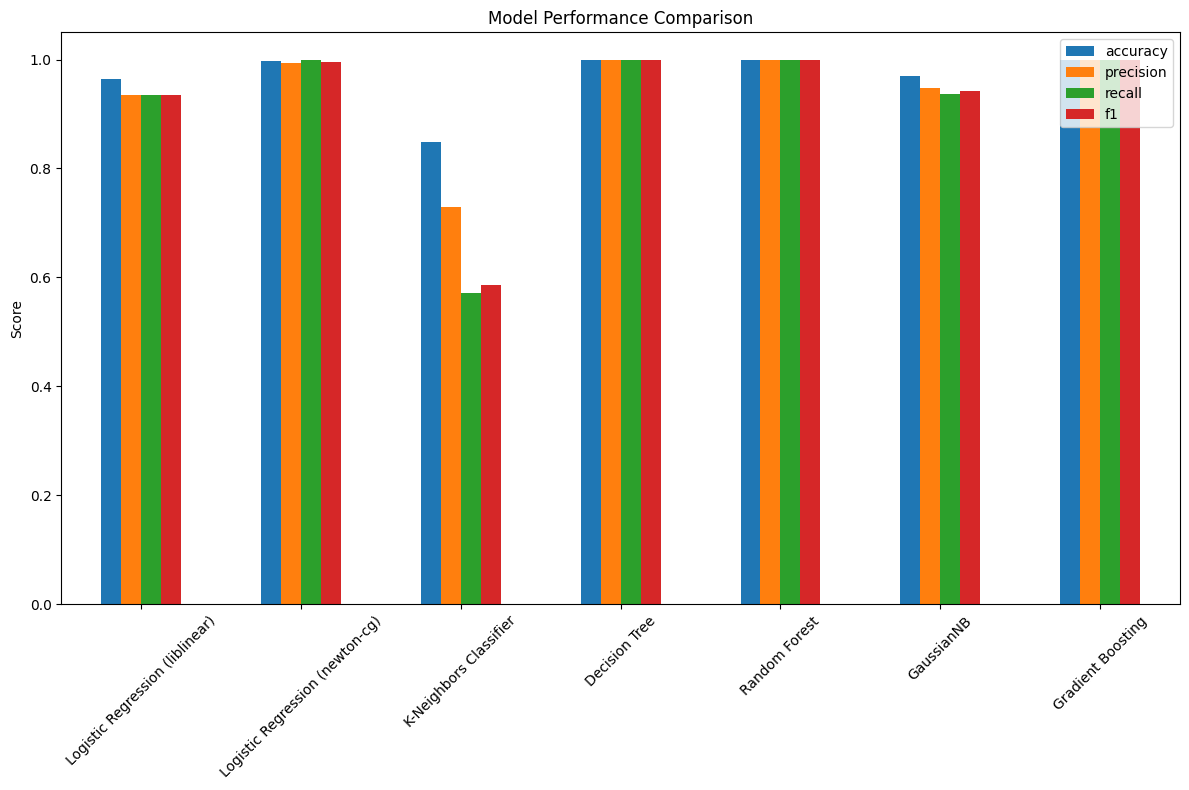

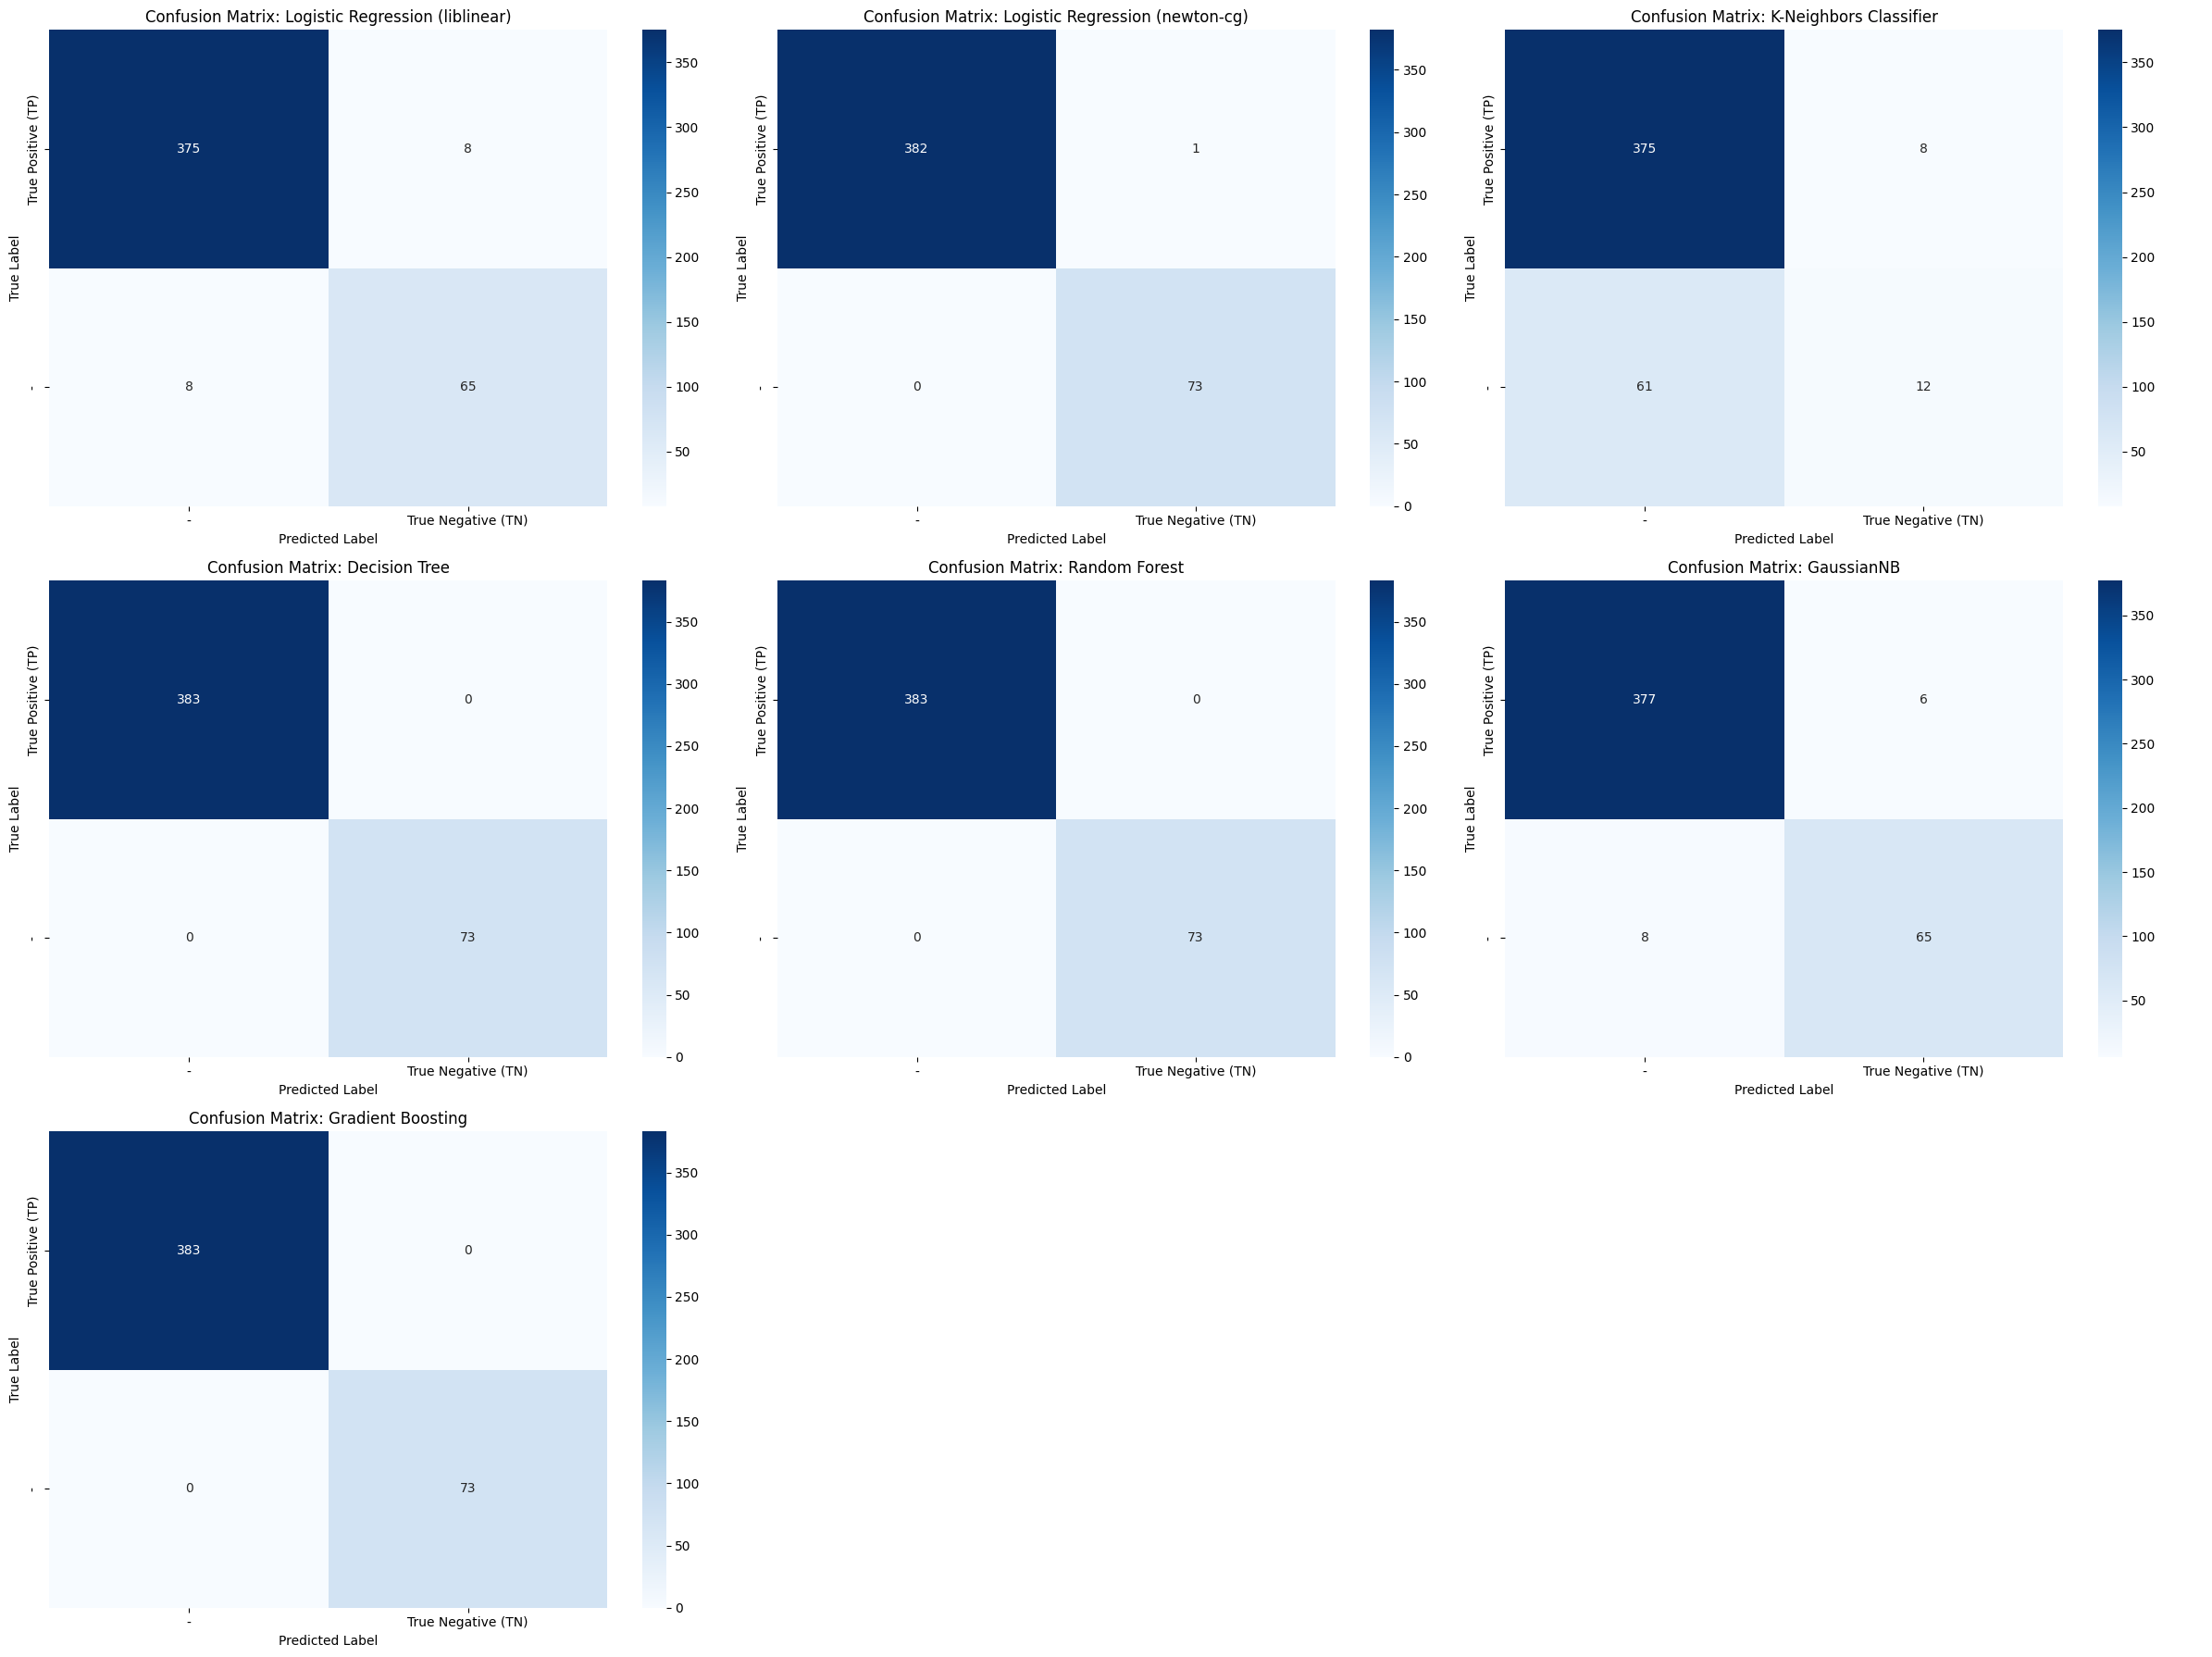

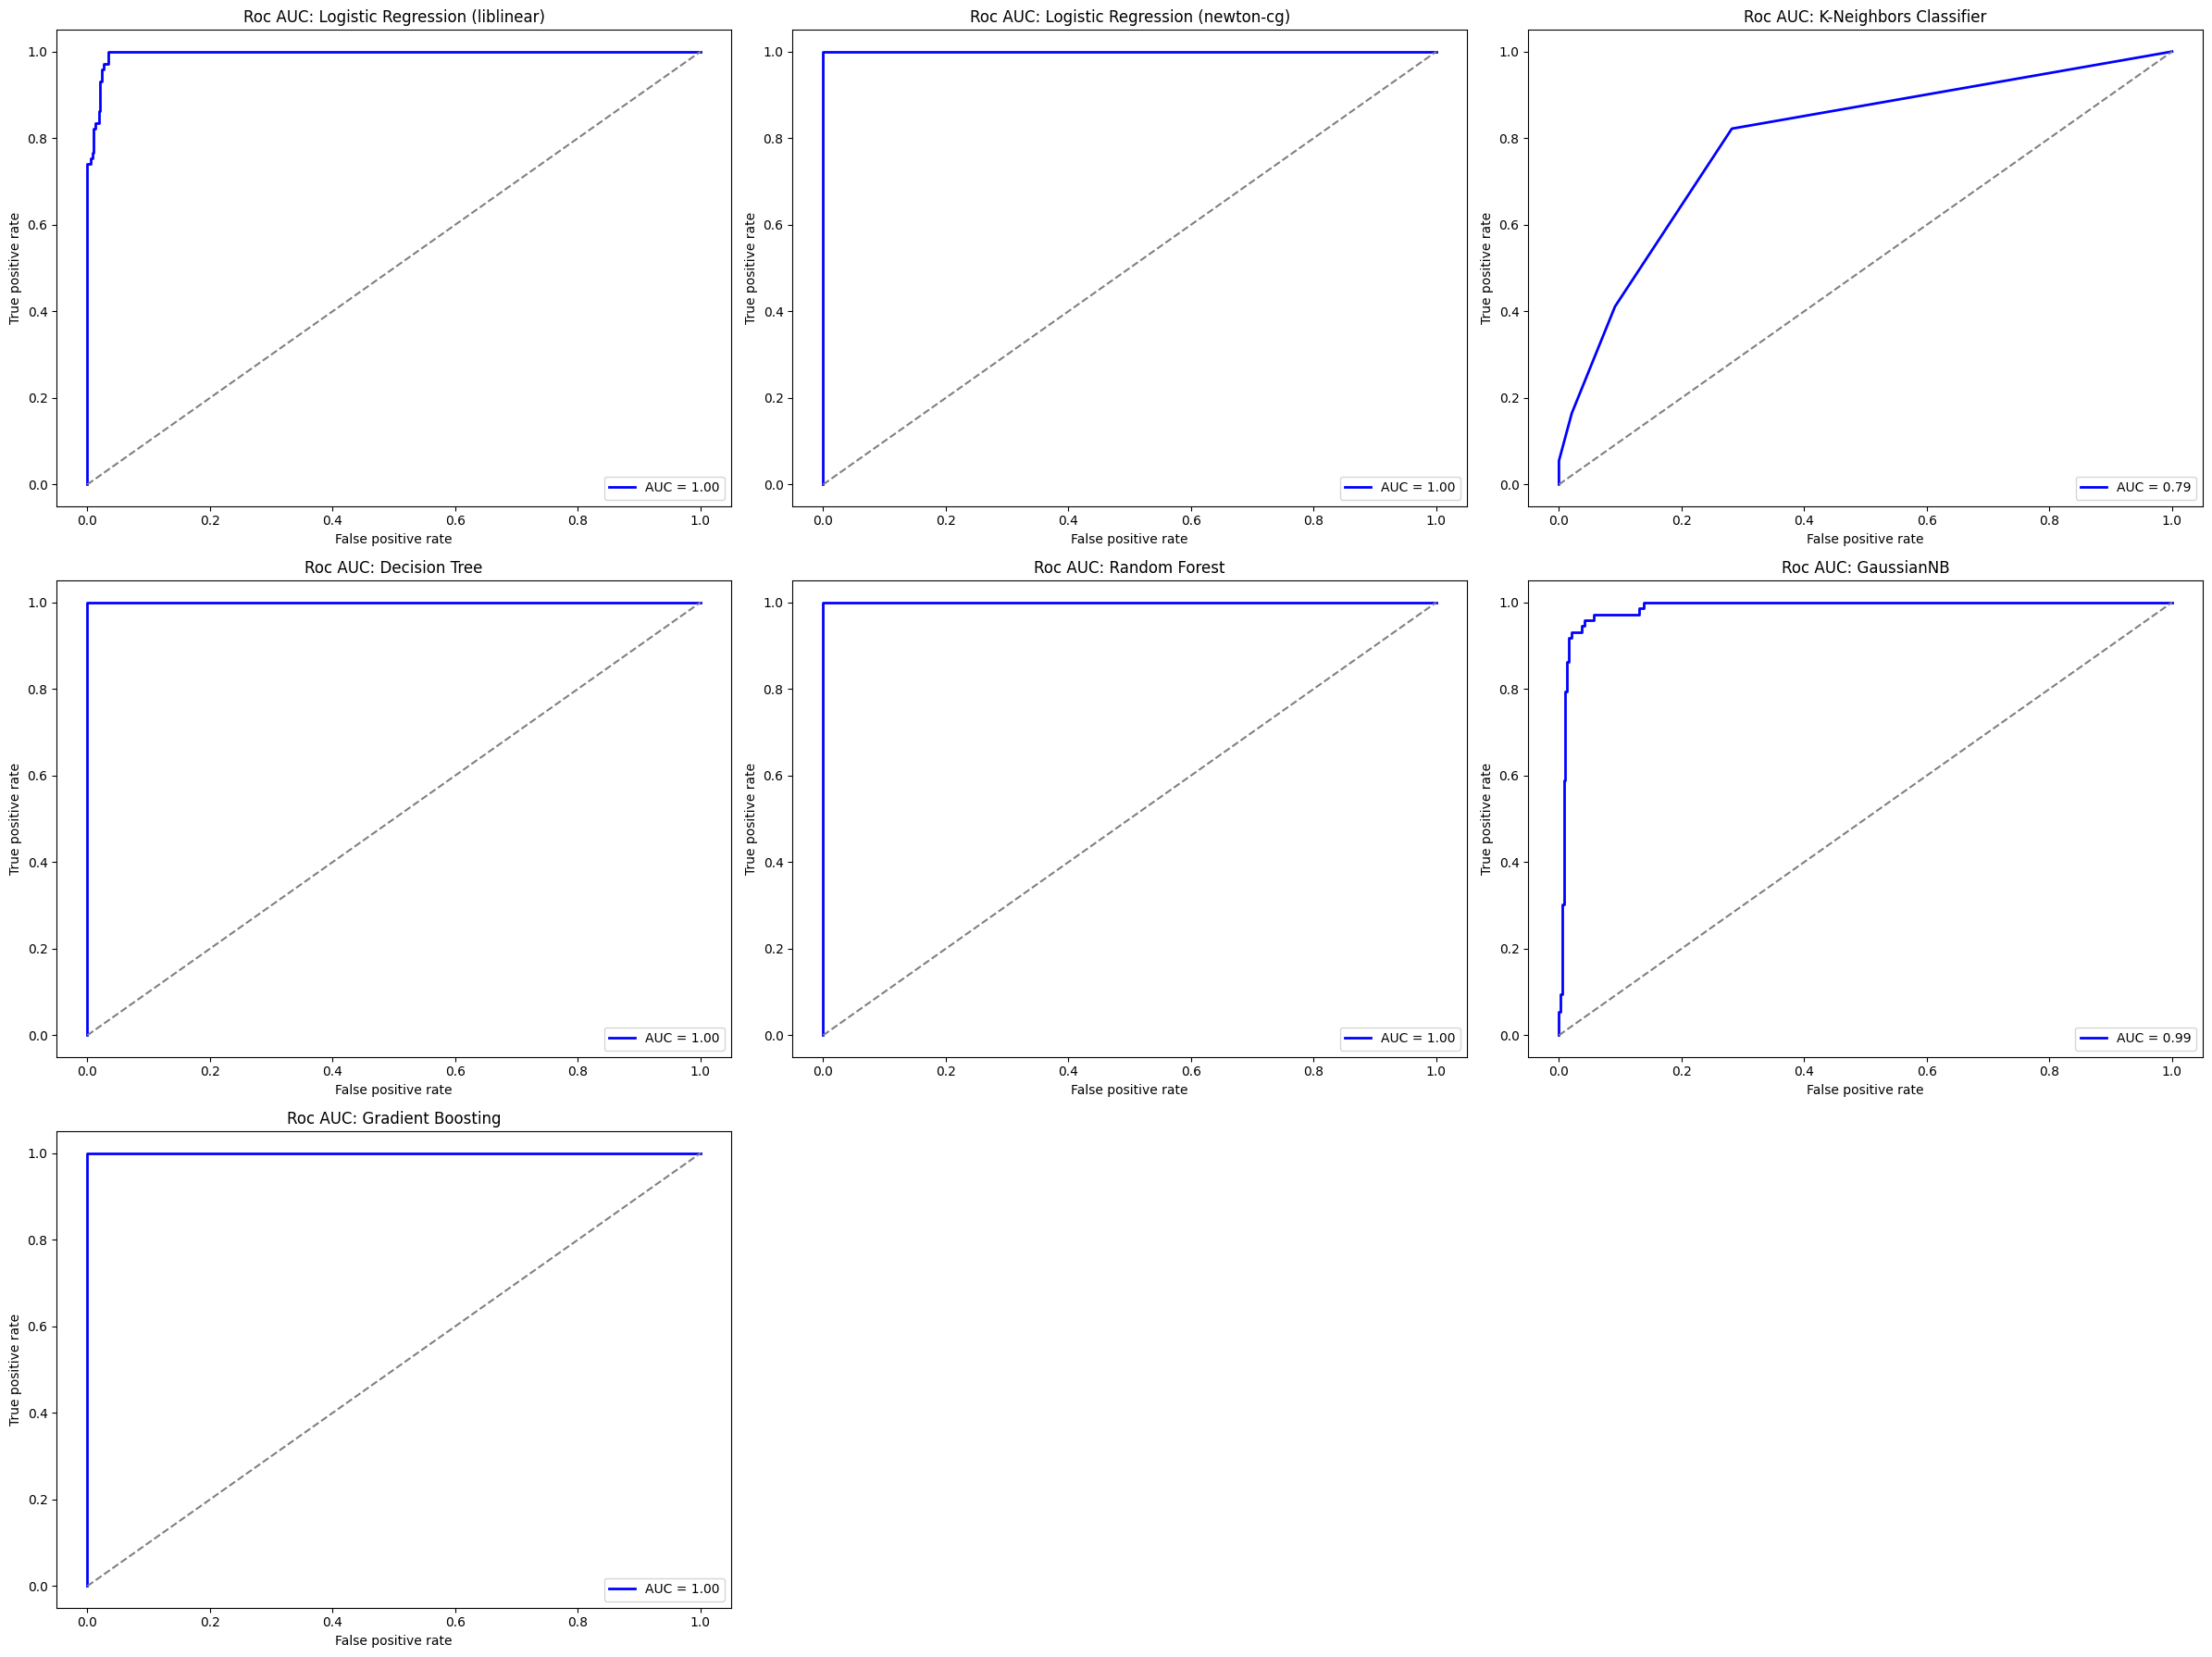

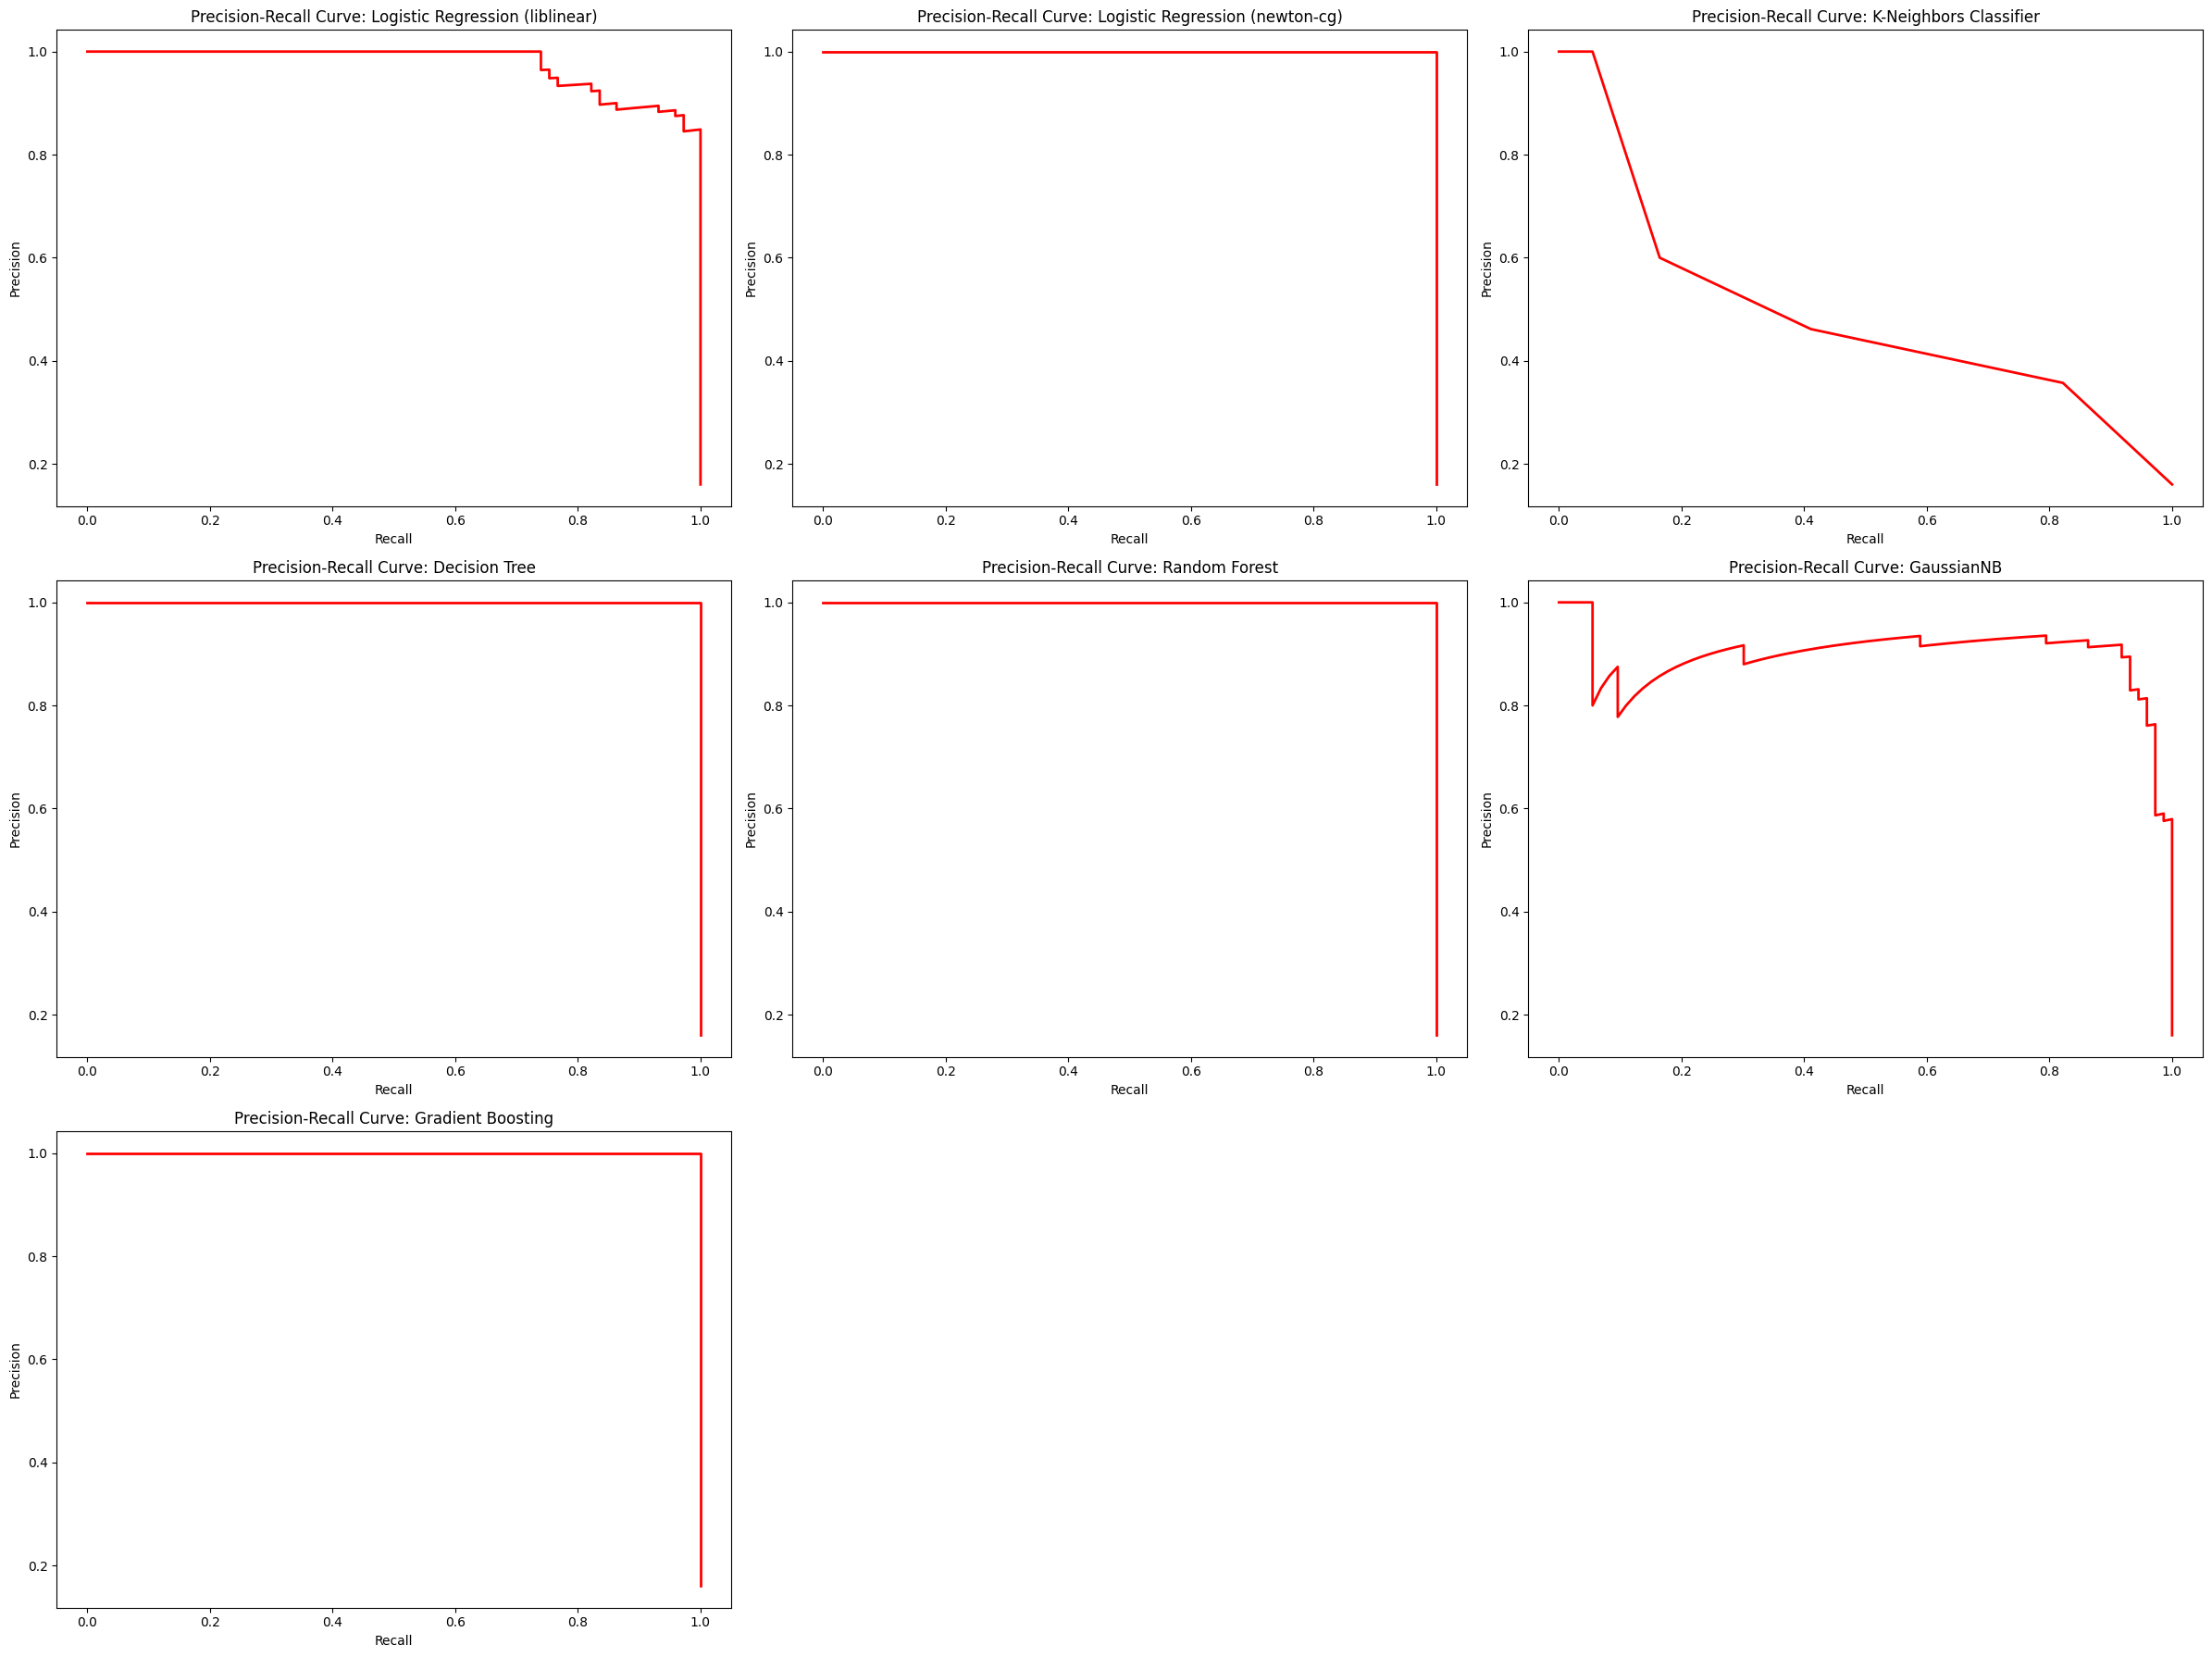

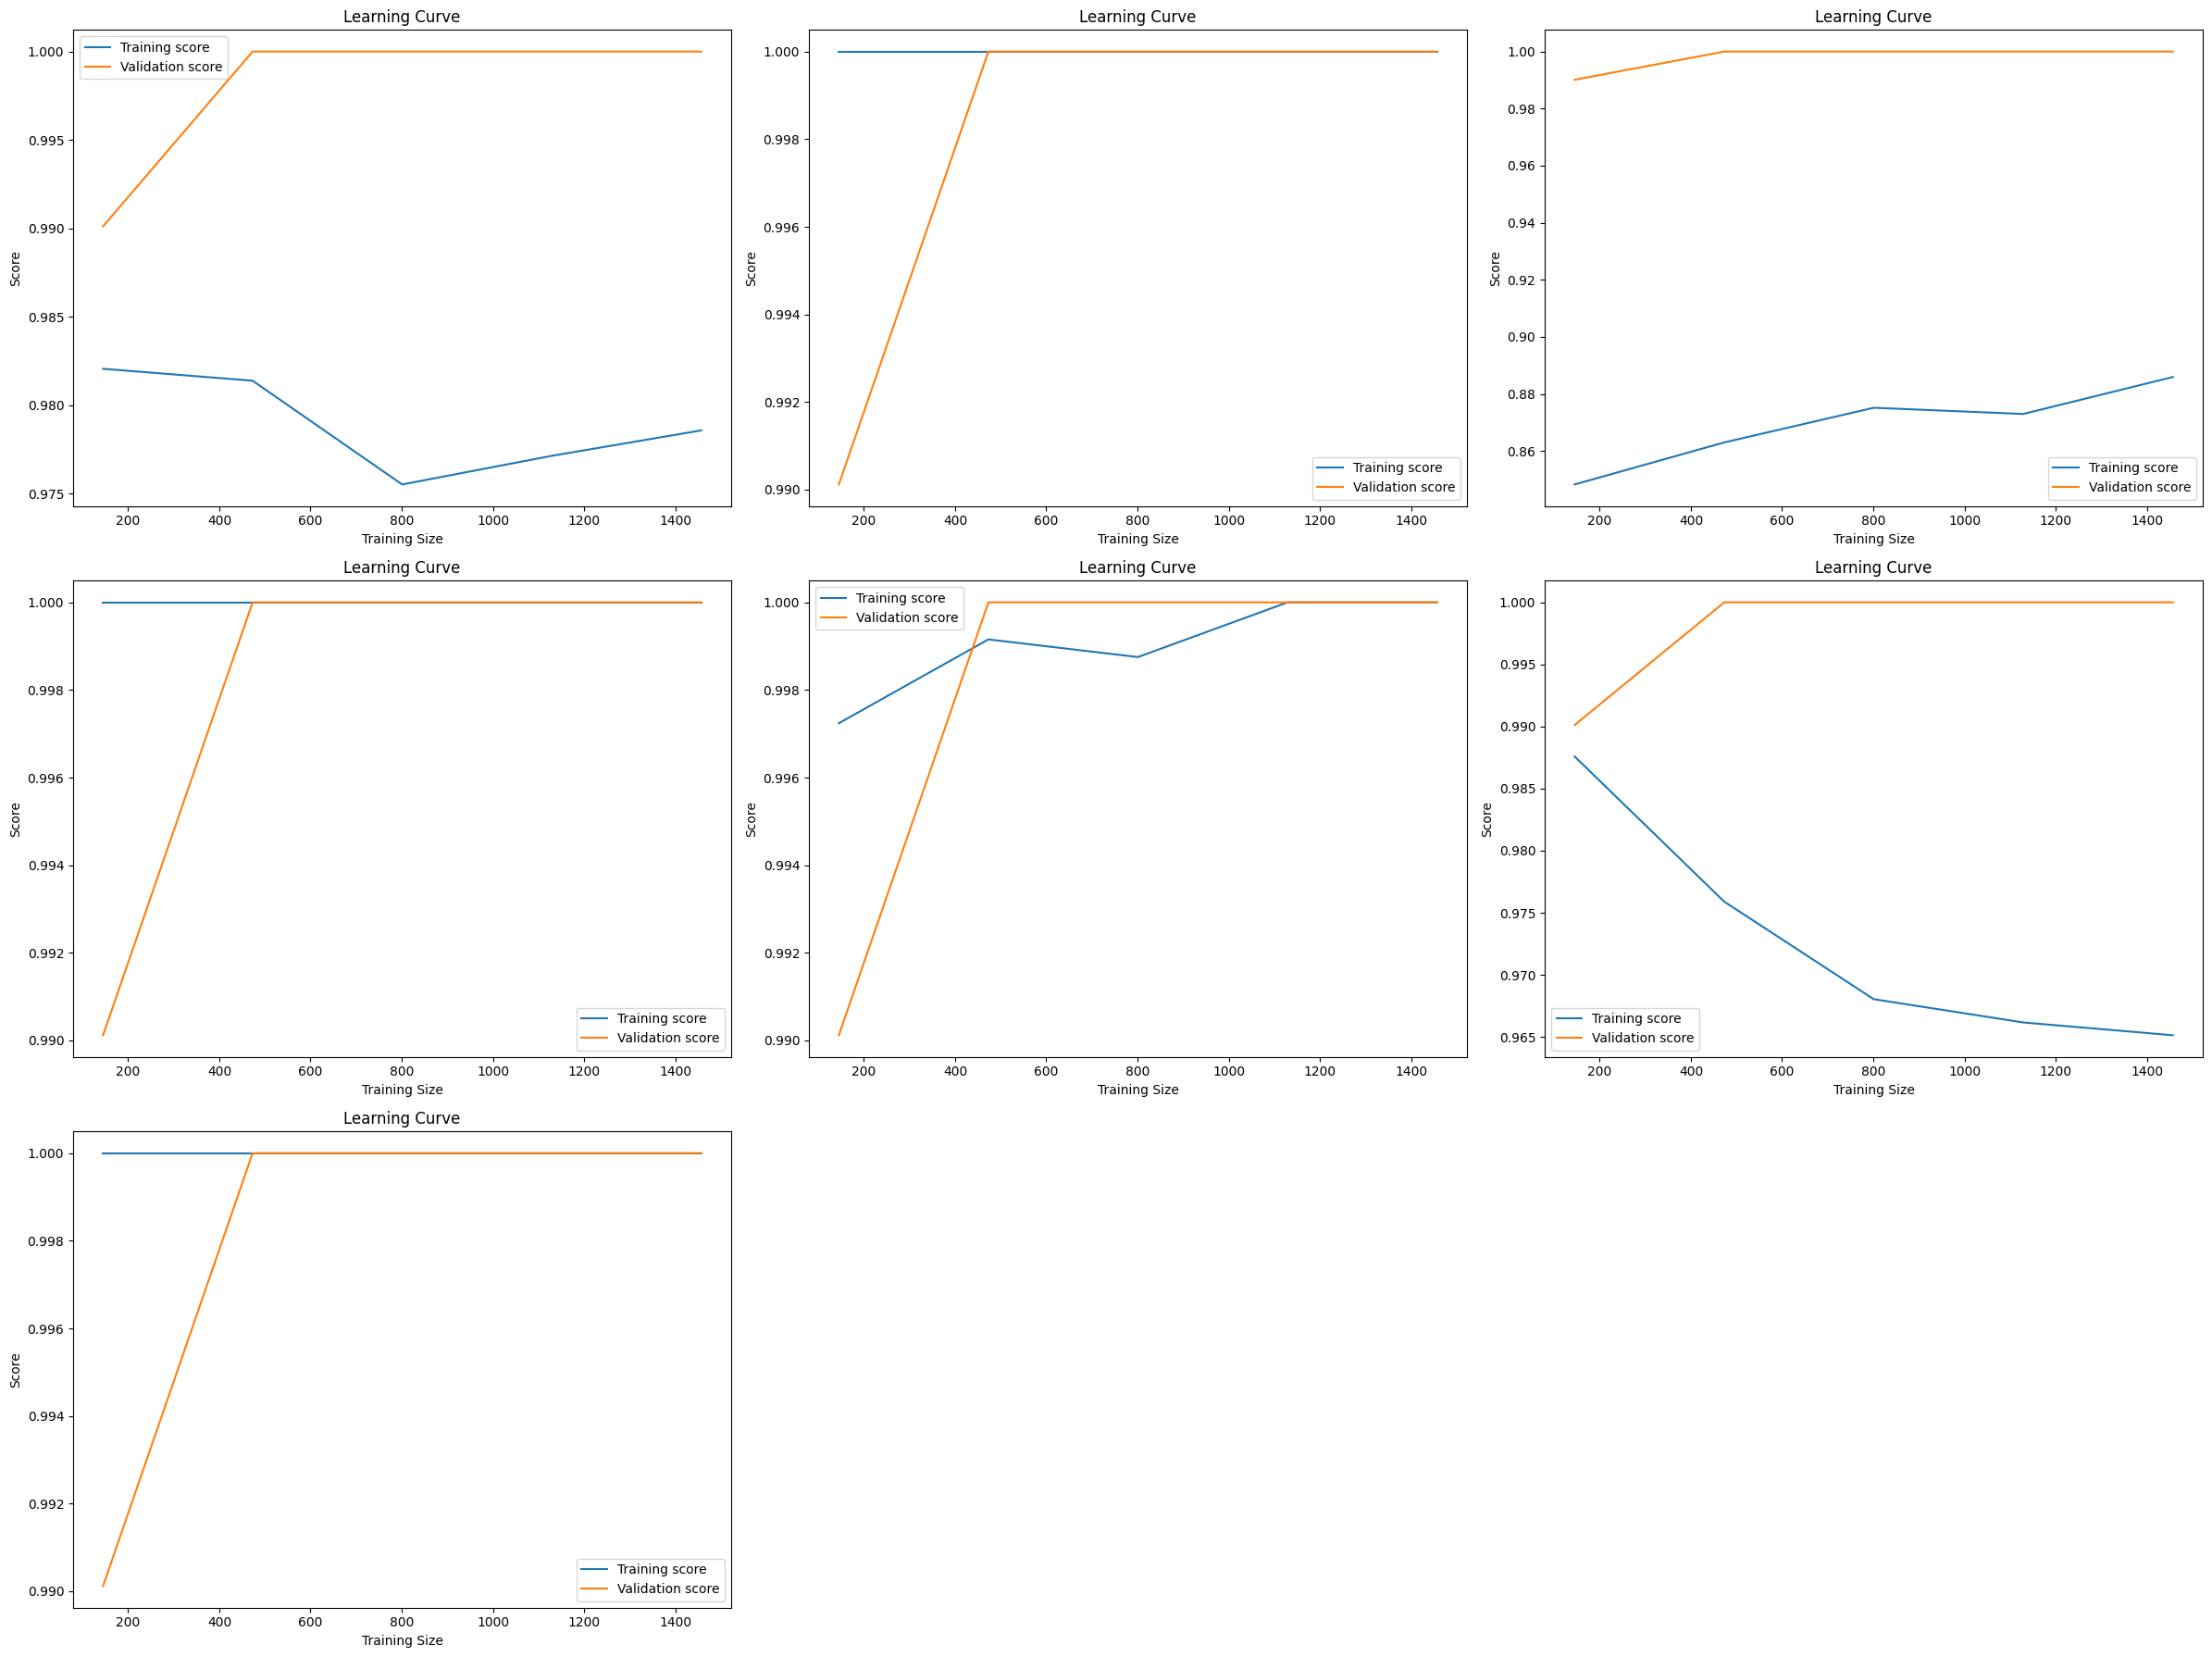

In [367]:
models = {
    'Logistic Regression (liblinear)': LogisticRegression(solver='liblinear'),
    'Logistic Regression (newton-cg)': LogisticRegression(max_iter=200, solver='newton-cg'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(max_depth=2, min_samples_split=2, n_estimators=100),
    'GaussianNB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(ccp_alpha=0.01, loss='log_loss', max_depth=2)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    precision_c, recall_c, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, cv=5)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr, 
        'tpr': tpr,
        'roc_curve': roc_auc,
        'precision_curve': precision_c,
        'recall_curve': recall_c,
        'train_sizes':train_sizes,
        'train_scores':train_scores,
        'validation_scores': validation_scores
    }

metrics_df = pd.DataFrame(results).T
metrics_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
labels = ['-', 'True Negative (TN)', 'True Positive (TP)', '-']
for i, model_name in enumerate(models.keys()):
    cm = results[model_name]['confusion_matrix']
    cm_reshaped = cm.reshape(2, 2)
    sns.heatmap(cm_reshaped, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels[:2], yticklabels=labels[2:], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['roc_curve']
    axes[i].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i].set_title(f'Roc AUC: {model_name}')
    axes[i].set_xlabel('False positive rate')
    axes[i].set_ylabel('True positive rate')
    axes[i].legend(loc='lower right')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    recall = results[model_name]['recall_curve']
    precision = results[model_name]['precision_curve']
    axes[i].plot(recall, precision, color='red', lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {model_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    train_size = results[model_name]['train_sizes']
    train_scores = results[model_name]['train_scores']
    valid_scores = results[model_name]['validation_scores']
    param_range = np.arange(1, 10, 1)
    axes[i].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[i].plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation score')
    axes[i].set_title('Learning Curve')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('Score')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


